# Variational Autoencoder (VAE) with Keras

Modified from code source: 

https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/#full-vae-code

This experimentation use a modified version of the free-spoken-digit-dataset : 

https://github.com/Jakobovski/free-spoken-digit-dataset

## Model imports

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy, KLD
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

# Following section allow using RTX graphic cards
# Found on StackOverflow: https://stackoverflow.com/questions/57062456/function-call-stack-keras-scratch-graph-error
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Loading data

In [2]:
import pathlib
import os
from scipy.io import wavfile

# Load FSDD dataset
data_paths = ('./datasets/free-spoken-digit-dataset/training-recordings', 
              './datasets/free-spoken-digit-dataset/testing-recordings')
data_paths = [pathlib.Path(path) for path in data_paths]
list_data = [tf.data.Dataset.list_files(str(path/'*.wav')) for path in data_paths]

def process_path(file_path):
    label = tf.strings.split(tf.strings.split(file_path, os.sep)[-1], '_')[0]
    raw_audio = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(raw_audio)
    audio = tf.reshape(audio, [-1])
    # TODO: add config values for frame_length and frame_step
    spectrogram = tf.signal.stft(audio, 512, 128, fft_length=512)
    spectrogram = tf.slice(spectrogram, [0,0], [-1, 128])
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.square(spectrogram)
    spectrogram = tf.math.l2_normalize(spectrogram, axis=1)
    dim = tf.shape(spectrogram)[0]
    if (dim < 32):
        bottom_pad = tf.cast(tf.math.floor((32 - dim) / 2), tf.int32)
        top_pad = tf.cast(tf.math.ceil((32 - dim) / 2), tf.int32)
        paddings = [[bottom_pad, top_pad], [0, 0]]
        spectrogram = tf.pad(spectrogram, paddings)
    spectrogram = spectrogram[:32,:]
    return spectrogram, label

labeled_data = [data_path.map(process_path) for data_path in list_data]

def reconstruct_wav(spectrogram, sample_rate, sqrt=False):
    spectrogram = tf.square(spectrogram)
    spectrogram = tf.pad(spectrogram, [[0, 0], [0, 129]])
    spectrogram = tf.cast(spectrogram, tf.complex64)
    audio = tf.signal.inverse_stft(spectrogram, 512, 128, fft_length=512)
    audio = tf.reshape(audio, [-1, 1])
    audio = audio * 128
    raw_audio = tf.audio.encode_wav(audio, sample_rate)
    return raw_audio

# Uncomment to generate audio file and check the spectrogram of the reconstructed audio.
'''
for (i, (image, target)) in enumerate(labeled_data[0].take(4)):
    raw_audio = reconstruct_wav(image, 8000)
    tf.io.write_file('./temp/' + str(target.numpy()) + '_reconstructed_' + str(i) + '.wav', raw_audio)
    plt.figure()
    plt.imshow(tf.transpose(image))
    plt.colorbar()
'''

"\nfor (i, (image, target)) in enumerate(labeled_data[0].take(4)):\n    raw_audio = reconstruct_wav(image, 8000)\n    tf.io.write_file('./temp/outputs/' + str(target.numpy()) + '_reconstructed_' + str(i) + '.wav', raw_audio)\n    plt.figure()\n    plt.imshow(tf.transpose(image))\n    plt.colorbar()\n"

In [3]:
(labeled_train_data, labeled_test_data) = labeled_data
# Use a great batch count compared to audio files count to use all examples available
input_train, target_train = next(iter(labeled_train_data.batch(20000).repeat(3)))
input_test, target_test = next(iter(labeled_test_data.batch(20000)))

## Model configuration

In [4]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 1000
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

## Data preprocessing

In [5]:
# Reshape data
input_train = tf.reshape(input_train, [input_train.shape[0], img_width, img_height, num_channels])
input_test = tf.reshape(input_test, [input_test.shape[0], img_width, img_height, num_channels])
input_shape = (img_width, img_height, num_channels)

# Parse numbers as floats (which presumably speeds up the training process)
input_train = tf.cast(input_train, tf.float32)
input_test = tf.cast(input_test, tf.float32)

# Define padding required to get a multiple of 8 as dimensions 
# (for better performances on tensor cores)
input_padding = ((0, 0), (0, 0))
v_pad = img_height % 8
h_pad = img_width % 8

if v_pad != 0 or h_pad != 0:
    top_pad = v_pad // 2
    left_pad = h_pad // 2
    input_padding = ((top_pad, v_pad - top_pad), (left_pad, h_pad - left_pad))

## Creating the encoder

### Encoder definition

In [6]:
# Definition
i = Input(shape=input_shape, name='encoder_input')
cx = ZeroPadding2D(padding=input_padding)(i)
cx = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx = BatchNormalization()(cx)
cx = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx = BatchNormalization()(cx)
x = Flatten()(cx)
x = Dense(20, activation='relu', kernel_initializer = 'he_normal')(x)
x = BatchNormalization()(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

### Reparameterization trick

In [7]:
# Define sampling with reparameterization trick
@tf.function
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return mu + tf.exp(0.5 * sigma) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

### Encoder instantiation

In [8]:
# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 32, 128, 1)   0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 64, 8)    80          zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 64, 8)    32          conv2d[0][0]                     
____________________________________________________________________________________________

## Creating the decoder

### Decoder definition

In [9]:
# Definition
d_i = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu', kernel_initializer = 'he_normal')(d_i)
x = BatchNormalization()(x)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(x)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same')(cx)
o = Cropping2D(input_padding, name='decoder_output')(cx)

### Decoder instantiation

In [10]:
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              12288     
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
reshape (Reshape)            (None, 8, 32, 16)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 64, 16)        2320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 64, 16)        64        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 128, 8)        1160

## Creating the whole VAE

In [11]:
# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 128, 1)]      0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 83448     
_________________________________________________________________
decoder (Model)              (None, 32, 128, 1)        32321     
Total params: 115,769
Trainable params: 107,441
Non-trainable params: 8,328
_________________________________________________________________


## Defining custom VAE loss function

In [12]:
# Define loss
@tf.function
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)
    

## Compilation & training

In [13]:
# Compile with tf optimiser to use tensor cores
opt = tf.keras.optimizers.Adam()
opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
vae.compile(optimizer=opt, loss=kl_reconstruction_loss, experimental_run_tf_function=False)

In [14]:
# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 1440 samples, validate on 360 samples
Epoch 1/1000
1440/1440 [==============================] - 4s 2ms/sample - loss: 3516.8530 - val_loss: 2893.0221
Epoch 2/1000
1440/1440 [==============================] - 0s 254us/sample - loss: 3199.0054 - val_loss: 2824.6711
Epoch 3/1000
1440/1440 [==============================] - 0s 255us/sample - loss: 2909.5845 - val_loss: 2762.3951
Epoch 4/1000
1440/1440 [==============================] - 0s 211us/sample - loss: 2714.9199 - val_loss: 2639.7171
Epoch 5/1000
1440/1440 [==============================] - 0s 251us/sample - loss: 2520.4631 - val_loss: 2506.9239
Epoch 6/1000
1440/1440 [==============================] - 0s 263us/sample - loss: 2301.3786 - val_loss: 2317.4619
Epoch 7/1000
1440/1440 [==============================] - 0s 258us/sample - loss: 2062.4996 - val_loss: 2100.4612
Epoch 8/1000
1440/1440 [==============================] - 0s 265us/sample - loss: 1793.9038 - val_loss: 1798.2964
Epoch 9/1000
1440/1440 [===================

Epoch 73/1000
1440/1440 [==============================] - 0s 187us/sample - loss: 278.8077 - val_loss: 302.8601
Epoch 74/1000
1440/1440 [==============================] - 0s 182us/sample - loss: 278.7840 - val_loss: 302.5820
Epoch 75/1000
1440/1440 [==============================] - 0s 187us/sample - loss: 278.4276 - val_loss: 301.7263
Epoch 76/1000
1440/1440 [==============================] - 0s 183us/sample - loss: 277.6120 - val_loss: 301.6093
Epoch 77/1000
1440/1440 [==============================] - 0s 187us/sample - loss: 277.0168 - val_loss: 302.1842
Epoch 78/1000
1440/1440 [==============================] - 0s 184us/sample - loss: 276.8680 - val_loss: 300.2304
Epoch 79/1000
1440/1440 [==============================] - 0s 186us/sample - loss: 276.8150 - val_loss: 299.7370
Epoch 80/1000
1440/1440 [==============================] - 0s 182us/sample - loss: 275.8593 - val_loss: 300.0035
Epoch 81/1000
1440/1440 [==============================] - 0s 188us/sample - loss: 275.3102 - va

1440/1440 [==============================] - 0s 185us/sample - loss: 258.8715 - val_loss: 286.3597
Epoch 146/1000
1440/1440 [==============================] - 0s 150us/sample - loss: 258.6110 - val_loss: 287.2066
Epoch 147/1000
1440/1440 [==============================] - 0s 157us/sample - loss: 258.6898 - val_loss: 286.8477
Epoch 148/1000
1440/1440 [==============================] - 0s 150us/sample - loss: 258.3677 - val_loss: 286.8345
Epoch 149/1000
1440/1440 [==============================] - 0s 150us/sample - loss: 258.0376 - val_loss: 286.5501
Epoch 150/1000
1440/1440 [==============================] - 0s 154us/sample - loss: 257.7924 - val_loss: 286.4190
Epoch 151/1000
1440/1440 [==============================] - 0s 149us/sample - loss: 257.7603 - val_loss: 286.4559
Epoch 152/1000
1440/1440 [==============================] - 0s 149us/sample - loss: 257.9535 - val_loss: 287.4185
Epoch 153/1000
1440/1440 [==============================] - 0s 171us/sample - loss: 257.5088 - val_loss

Epoch 217/1000
1440/1440 [==============================] - 0s 148us/sample - loss: 252.1628 - val_loss: 284.2692
Epoch 218/1000
1440/1440 [==============================] - 0s 149us/sample - loss: 252.4542 - val_loss: 284.4715
Epoch 219/1000
1440/1440 [==============================] - 0s 149us/sample - loss: 252.1714 - val_loss: 284.7980
Epoch 220/1000
1440/1440 [==============================] - 0s 147us/sample - loss: 252.6105 - val_loss: 283.9869
Epoch 221/1000
1440/1440 [==============================] - 0s 155us/sample - loss: 252.0721 - val_loss: 284.2962
Epoch 222/1000
1440/1440 [==============================] - 0s 184us/sample - loss: 252.4376 - val_loss: 284.3503
Epoch 223/1000
1440/1440 [==============================] - 0s 185us/sample - loss: 252.0224 - val_loss: 284.3545
Epoch 224/1000
1440/1440 [==============================] - 0s 191us/sample - loss: 251.7741 - val_loss: 284.3260
Epoch 225/1000
1440/1440 [==============================] - 0s 183us/sample - loss: 251.

Epoch 289/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 249.7950 - val_loss: 284.7154
Epoch 290/1000
1440/1440 [==============================] - 0s 157us/sample - loss: 249.5308 - val_loss: 283.6931
Epoch 291/1000
1440/1440 [==============================] - 0s 150us/sample - loss: 249.6518 - val_loss: 283.8719
Epoch 292/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 249.0829 - val_loss: 284.1310
Epoch 293/1000
1440/1440 [==============================] - 0s 166us/sample - loss: 249.3615 - val_loss: 283.7647
Epoch 294/1000
1440/1440 [==============================] - 0s 162us/sample - loss: 249.7808 - val_loss: 284.0317
Epoch 295/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 248.7212 - val_loss: 284.0902
Epoch 296/1000
1440/1440 [==============================] - 0s 165us/sample - loss: 249.8889 - val_loss: 283.7656
Epoch 297/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 249.

Epoch 361/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 247.8325 - val_loss: 282.7973
Epoch 362/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 247.4269 - val_loss: 283.0738
Epoch 363/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 247.7698 - val_loss: 282.6684
Epoch 364/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 247.3709 - val_loss: 283.1454
Epoch 365/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 247.4777 - val_loss: 283.7796
Epoch 366/1000
1440/1440 [==============================] - 0s 159us/sample - loss: 247.1329 - val_loss: 283.3476
Epoch 367/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 247.7182 - val_loss: 283.1078
Epoch 368/1000
1440/1440 [==============================] - 0s 150us/sample - loss: 247.9132 - val_loss: 283.3161
Epoch 369/1000
1440/1440 [==============================] - 0s 156us/sample - loss: 247.

Epoch 433/1000
1440/1440 [==============================] - 0s 164us/sample - loss: 246.6711 - val_loss: 282.8022
Epoch 434/1000
1440/1440 [==============================] - 0s 171us/sample - loss: 247.1169 - val_loss: 282.4313
Epoch 435/1000
1440/1440 [==============================] - 0s 167us/sample - loss: 246.5025 - val_loss: 282.3454
Epoch 436/1000
1440/1440 [==============================] - 0s 169us/sample - loss: 246.4802 - val_loss: 284.3911
Epoch 437/1000
1440/1440 [==============================] - 0s 156us/sample - loss: 247.1162 - val_loss: 282.8527
Epoch 438/1000
1440/1440 [==============================] - 0s 159us/sample - loss: 247.7137 - val_loss: 283.7348
Epoch 439/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 246.9425 - val_loss: 282.8071
Epoch 440/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 246.6082 - val_loss: 282.4307
Epoch 441/1000
1440/1440 [==============================] - 0s 174us/sample - loss: 246.

Epoch 505/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 246.0738 - val_loss: 282.5630
Epoch 506/1000
1440/1440 [==============================] - 0s 151us/sample - loss: 245.9659 - val_loss: 282.8581
Epoch 507/1000
1440/1440 [==============================] - 0s 157us/sample - loss: 246.2876 - val_loss: 283.0272
Epoch 508/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 244.8936 - val_loss: 283.0167
Epoch 509/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 245.5411 - val_loss: 282.3526
Epoch 510/1000
1440/1440 [==============================] - 0s 167us/sample - loss: 245.6592 - val_loss: 282.1231
Epoch 511/1000
1440/1440 [==============================] - 0s 164us/sample - loss: 246.0045 - val_loss: 282.4812
Epoch 512/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 245.4510 - val_loss: 282.4675
Epoch 513/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 245.

Epoch 577/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 245.1289 - val_loss: 283.8714
Epoch 578/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 244.4065 - val_loss: 283.0363
Epoch 579/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 245.8599 - val_loss: 282.6139
Epoch 580/1000
1440/1440 [==============================] - 0s 158us/sample - loss: 245.7018 - val_loss: 283.3565
Epoch 581/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 244.8273 - val_loss: 282.9469
Epoch 582/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 245.1924 - val_loss: 283.4517
Epoch 583/1000
1440/1440 [==============================] - 0s 159us/sample - loss: 245.5916 - val_loss: 283.2990
Epoch 584/1000
1440/1440 [==============================] - 0s 153us/sample - loss: 246.2618 - val_loss: 283.1339
Epoch 585/1000
1440/1440 [==============================] - 0s 153us/sample - loss: 246.

Epoch 649/1000
1440/1440 [==============================] - 0s 164us/sample - loss: 244.3673 - val_loss: 283.3847
Epoch 650/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 244.6359 - val_loss: 284.1405
Epoch 651/1000
1440/1440 [==============================] - 0s 164us/sample - loss: 244.5721 - val_loss: 282.9646
Epoch 652/1000
1440/1440 [==============================] - 0s 167us/sample - loss: 245.3067 - val_loss: 282.1388
Epoch 653/1000
1440/1440 [==============================] - 0s 155us/sample - loss: 244.2781 - val_loss: 282.7518
Epoch 654/1000
1440/1440 [==============================] - 0s 155us/sample - loss: 244.8412 - val_loss: 283.7497
Epoch 655/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 244.3612 - val_loss: 283.3579
Epoch 656/1000
1440/1440 [==============================] - 0s 162us/sample - loss: 244.8512 - val_loss: 282.9337
Epoch 657/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 244.

Epoch 721/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 244.7792 - val_loss: 283.2811
Epoch 722/1000
1440/1440 [==============================] - 0s 153us/sample - loss: 244.6304 - val_loss: 283.5184
Epoch 723/1000
1440/1440 [==============================] - 0s 153us/sample - loss: 244.1328 - val_loss: 282.2568
Epoch 724/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 243.7768 - val_loss: 282.7604
Epoch 725/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 244.4244 - val_loss: 283.3183
Epoch 726/1000
1440/1440 [==============================] - 0s 158us/sample - loss: 244.4260 - val_loss: 282.4994
Epoch 727/1000
1440/1440 [==============================] - 0s 159us/sample - loss: 244.3823 - val_loss: 282.9407
Epoch 728/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 243.4082 - val_loss: 283.2242
Epoch 729/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 244.

Epoch 793/1000
1440/1440 [==============================] - 0s 157us/sample - loss: 244.1626 - val_loss: 282.8081
Epoch 794/1000
1440/1440 [==============================] - 0s 162us/sample - loss: 244.3599 - val_loss: 282.4663
Epoch 795/1000
1440/1440 [==============================] - 0s 165us/sample - loss: 243.6089 - val_loss: 282.6214
Epoch 796/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 243.5451 - val_loss: 283.0409
Epoch 797/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 244.2918 - val_loss: 281.7393
Epoch 798/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 243.9837 - val_loss: 282.1037
Epoch 799/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 245.2941 - val_loss: 282.8145
Epoch 800/1000
1440/1440 [==============================] - 0s 156us/sample - loss: 244.8532 - val_loss: 282.1845
Epoch 801/1000
1440/1440 [==============================] - 0s 150us/sample - loss: 243.

Epoch 865/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 243.2517 - val_loss: 283.2940
Epoch 866/1000
1440/1440 [==============================] - 0s 159us/sample - loss: 243.3010 - val_loss: 283.8859
Epoch 867/1000
1440/1440 [==============================] - 0s 162us/sample - loss: 243.2488 - val_loss: 283.4370
Epoch 868/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 244.2380 - val_loss: 284.1437
Epoch 869/1000
1440/1440 [==============================] - 0s 152us/sample - loss: 243.6220 - val_loss: 284.1457
Epoch 870/1000
1440/1440 [==============================] - 0s 154us/sample - loss: 243.9879 - val_loss: 284.6866
Epoch 871/1000
1440/1440 [==============================] - 0s 159us/sample - loss: 244.0093 - val_loss: 282.1089
Epoch 872/1000
1440/1440 [==============================] - 0s 162us/sample - loss: 243.5410 - val_loss: 283.6309
Epoch 873/1000
1440/1440 [==============================] - 0s 161us/sample - loss: 243.

Epoch 937/1000
1440/1440 [==============================] - 0s 159us/sample - loss: 243.5964 - val_loss: 284.8089
Epoch 938/1000
1440/1440 [==============================] - 0s 158us/sample - loss: 242.9781 - val_loss: 286.2226
Epoch 939/1000
1440/1440 [==============================] - 0s 150us/sample - loss: 243.2046 - val_loss: 285.7166
Epoch 940/1000
1440/1440 [==============================] - 0s 158us/sample - loss: 244.5689 - val_loss: 286.3544
Epoch 941/1000
1440/1440 [==============================] - 0s 162us/sample - loss: 243.1396 - val_loss: 287.2744
Epoch 942/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 243.0260 - val_loss: 286.3040
Epoch 943/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 242.1917 - val_loss: 287.1576
Epoch 944/1000
1440/1440 [==============================] - 0s 160us/sample - loss: 242.8950 - val_loss: 286.7091
Epoch 945/1000
1440/1440 [==============================] - 0s 163us/sample - loss: 242.

## Visualizing VAE results

##### Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/
##### (François Chollet).

### Visualizing inputs mapped onto latent space

In [15]:
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(12.3, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

### Visualizing samples from the latent space

### Calling the visualizers

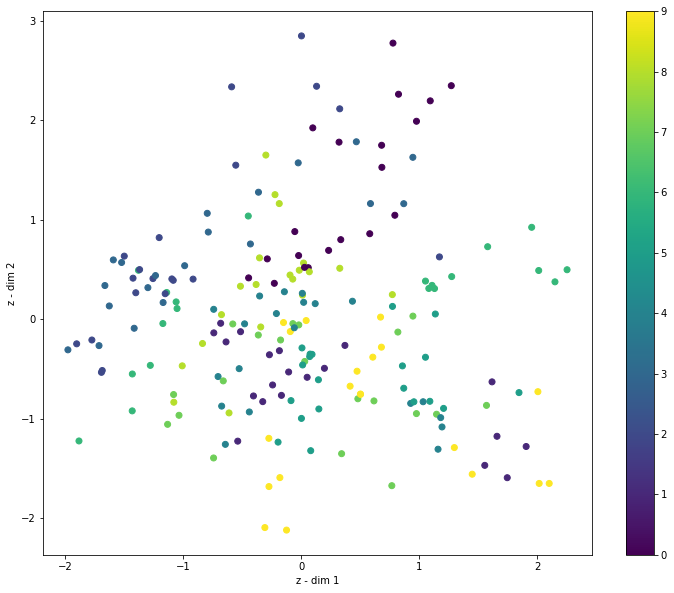

In [16]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)

## Compare examples with reconstructed image

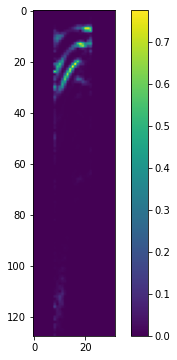

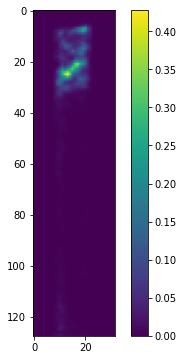

In [17]:
import numpy as np
from matplotlib import pyplot as plt

images = np.zeros((2, img_width, img_height, num_channels))
inputIndex = 12
inputNumber = input_test[inputIndex]
inputTarget = target_test[inputIndex]

# Create input image
imgInput = np.squeeze(inputNumber, axis=2)

# Create output image
data = decoder.predict(encoder.predict(tf.expand_dims(inputNumber, 0)))
data = data[0]
data = np.squeeze(data, axis=2)

# Reconstruct audio
audio = reconstruct_wav(imgInput, 8000)
tf.io.write_file('./outputs/' + str(inputTarget.numpy()) + '_reconstructed_.wav', audio)
audio = reconstruct_wav(data, 8000)
tf.io.write_file('./outputs/' + str(inputTarget.numpy()) + '_reconstructed_predicted.wav', audio)

# Display images
images = (imgInput, data)
    
for im in images:
    plt.figure(figsize=(6,6))
    plt.imshow(tf.transpose(im))
    plt.colorbar()

## Save & load models

### Simple VAE model

In [ ]:
# Save VAE weights
vae.save_weights('models/vae/vae')

In [ ]:
# Load VAE weights
vae.load_weights('models/vae/vae')

## DCGAN-like architecture

In [ ]:
no_epochs = 5

# Encoder definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = ZeroPadding2D(padding=input_padding)(i)
cx      = Conv2D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=256, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu', kernel_initializer = 'he_normal')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

# Decoder definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu', kernel_initializer = 'he_normal')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=512, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer = 'he_normal')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same')(cx)
o     = Cropping2D(input_padding, name='decoder_output')(cx)

In [ ]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)

In [ ]:
# Save DCGAN-like architecture models
vae.save_weights('models/dcgan-like/vae')

In [ ]:
# Load DCGAN-like architecture models
vae.load_weights('models/dcgan-like/vae')